# Shear profile of A360 using Anacal

Xiangchong Li, Prakruth Adari, Anja von der Linden\
LSST Science Piplines version: v29_0_0_rc5\
Container Size: large

This notebook is a condensed set of code to obtain a shear profile of Abell 360 using Anacal shear measurements. The main steps are:

- Loading in Anacal catalogs
- Shear profile
- Mass Map

In [62]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import os, sys, gc
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.stats as stats
from matplotlib import cm
from astropy.table import Table, join, vstack, hstack
from astropy.coordinates import SkyCoord


# Familiar stack packages
from lsst.daf.butler import Butler
import lsst.geom as geom

import clmm
from clmm import GalaxyCluster, ClusterEnsemble, GCData, Cosmology
from clmm import Cosmology, utils
cosmo = clmm.Cosmology(H0=70.0, Omega_dm0=0.3 - 0.045, Omega_b0=0.045, Omega_k0=0.0)

z_cl = 0.22

# source properties
# assume sources redshift following a the DESC SRD distribution. This will need updating.

z_distrib_func = utils.redshift_distributions.desc_srd  

# Compute first beta (e.g. eq(6) of WtGIII paper)
beta_kwargs = {
    "z_cl": z_cl,
    "z_inf": 10.0,
    "cosmo": cosmo,
    "z_distrib_func": z_distrib_func,
}
beta_s_mean = utils.compute_beta_s_mean_from_distribution(**beta_kwargs)
beta_s_square_mean = utils.compute_beta_s_square_mean_from_distribution(**beta_kwargs)
rproj = np.logspace(np.log10(0.3),np.log10(7.), 100)

In [2]:
arcsec = 1/60**2
rng = np.random.default_rng()
omega_m = .31
omega_de= .69
omega_r = 0
H0 = 70 # km/s/Mpc
c = 3e5 # km/s

Hz = lambda z : c/(H0  * np.sqrt((omega_de + omega_m * (1+z)**3 + omega_r * (1+z)**4)))
chi_dl = lambda z, z0=0 : integrate.quad(Hz, z0, z)[0]
Da = lambda z : chi_dl(z)/(1+z)
beta_r = lambda zl, zs : integrate.quad(Hz, zl, zs)[0]/integrate.quad(Hz, 0, zs)[0]

In [70]:
# Load operation rehearsal data
# Can use obs_butler.registry.queryCollections to see available collections
obs_repo = '/repo/main'
obs_repo = "dp1"
obs_collection = 'LSSTComCam/runs/DRP/DP1/v29_0_0_rc5/DM-49865'
obs_collection = "LSSTComCam/DP1"

obs_butler = Butler(obs_repo, collections=obs_collection)
obs_registry = obs_butler.registry

t_skymap = obs_butler.get('skyMap', skymap='lsst_cells_v1')

In [71]:
cluster_coords = (37.865017, 6.982205)
# Position of the BCG for A360
ra_bcg = cluster_coords[0]
dec_bcg = cluster_coords[1]

# Looking for all patches in delta deg region around it
delta = 0.5
center = geom.SpherePoint(ra_bcg, dec_bcg, geom.degrees)
ra_min, ra_max = ra_bcg - delta, ra_bcg + delta
dec_min, dec_max = dec_bcg - delta, dec_bcg + delta

ra_range = (ra_min, ra_max)
dec_range = (dec_min, dec_max)
radec = [geom.SpherePoint(ra_range[0], dec_range[0], geom.degrees),
         geom.SpherePoint(ra_range[0], dec_range[1], geom.degrees),
         geom.SpherePoint(ra_range[1], dec_range[0], geom.degrees),
         geom.SpherePoint(ra_range[1], dec_range[1], geom.degrees)]

tracts_and_patches = t_skymap.findTractPatchList(radec)

tp_dict = {}
for tract_num in np.arange(len(tracts_and_patches)):
    tract_info = tracts_and_patches[tract_num][0]
    tract_idx = tract_info.getId()
    # All the patches around the cluster
    patches = []
    for i,patch in enumerate(tracts_and_patches[tract_num][1]):
        patch_info = tracts_and_patches[tract_num][1][i]
        patch_idx = patch_info.sequential_index
        patches.append(patch_idx)
    tp_dict.update({tract_idx:patches})
print(tp_dict)

{10463: [30, 40, 50, 60, 70, 80, 90, 31, 41, 51, 61, 71, 81, 91, 32, 42, 52, 62, 72, 82, 92, 33, 43, 53, 63, 73, 83, 93, 34, 44, 54, 64, 74, 84, 94], 10704: [0, 1, 2, 3, 4, 5], 10464: [37, 47, 57, 67, 77, 87, 97, 38, 48, 58, 68, 78, 88, 98, 39, 49, 59, 69, 79, 89, 99], 10705: [8, 9]}


In [72]:
anacal_tables = []
mag_zero = 31.4
version = "v6"
if version == "v6" or version=="v7":
    for tid in tp_dict.keys():
        patches = tp_dict[tid]
        for p in patches:
            fname = f'/sdf/data/rubin/shared/cluster_commissioning/AnaCal/catalog_{version}/detect_{tid}-{p}.fits'
            fname2 = f'/sdf/data/rubin/shared/cluster_commissioning/AnaCal/catalog_{version}/force_{tid}-{p}.fits'
            if os.path.isfile(fname) and os.path.isfile(fname2):
                ana_table = Table.read(fname)
                ana_table2 = Table.read(fname2)
                anacal_tables.append(hstack([ana_table, ana_table2]))
            else:
                print(fname)
    anacal_table = vstack(anacal_tables)
    anacal_table['mag'] = mag_zero - np.log10(anacal_table['flux'] ) *2.5
    anacal_table['g_mag'] = mag_zero - np.log10(anacal_table['g_flux'] ) *2.5
    anacal_table['r_mag'] = mag_zero - np.log10(anacal_table['r_flux'] ) *2.5
    anacal_table['i_mag'] = mag_zero - np.log10(anacal_table['i_flux'] ) *2.5
    anacal_table['z_mag'] = mag_zero - np.log10(anacal_table['z_flux'] ) *2.5
else:
    for tid in tp_dict.keys():
        patches = tp_dict[tid]
        for p in patches:
            fname = f'/sdf/data/rubin/shared/cluster_commissioning/AnaCal/catalog_{version}/{tid}-{p}.fits'
            if os.path.isfile(fname):
                ana_table = Table.read(fname)
                anacal_tables.append(ana_table)
            else:
                print(fname)
    big_anacal_table = vstack(anacal_tables)
    anacal_table['mag'] = mag_zero - np.log10(anacal_table['flux'] ) *2.5

/tmp/ipykernel_1124/3817162874.py:18: RuntimeWarning: invalid value encountered in log10
  anacal_table['g_mag'] = mag_zero - np.log10(anacal_table['g_flux'] ) *2.5
/tmp/ipykernel_1124/3817162874.py:21: RuntimeWarning: invalid value encountered in log10
  anacal_table['z_mag'] = mag_zero - np.log10(anacal_table['z_flux'] ) *2.5


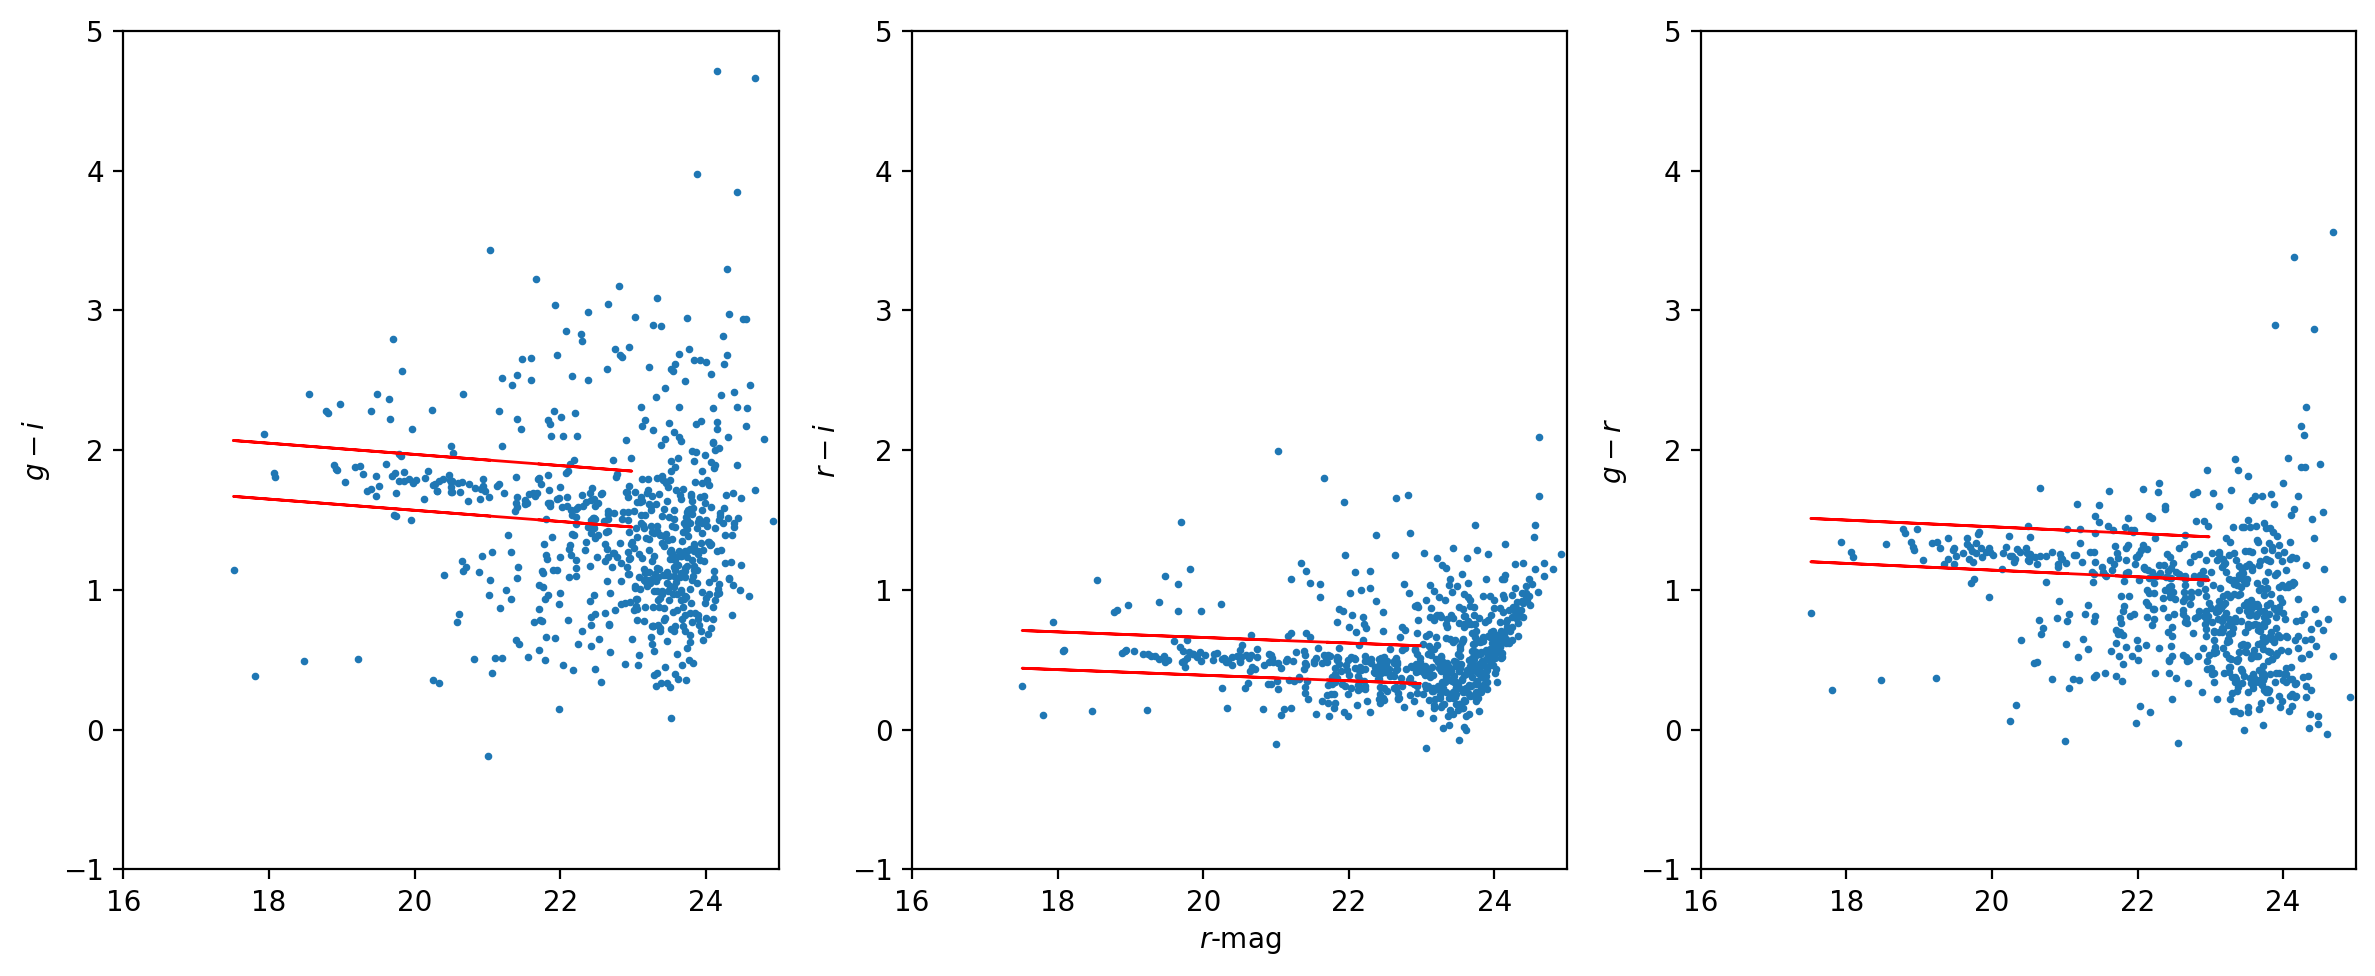

In [76]:
mag_lim = 23
gi_lims = (0.20, -0.20)
ri_lims = (0.12, -0.15)
gr_lims = (0.15, -0.16)
color_gi = anacal_table['g_mag'] - anacal_table['i_mag']
color_ri = anacal_table['r_mag'] - anacal_table['i_mag']
color_gr = anacal_table['g_mag'] - anacal_table['r_mag']
color_iz = anacal_table['i_mag'] - anacal_table['z_mag']
gi_line = (anacal_table['r_mag'] - 18) * (-0.20/5) + 1.85
ri_line = (anacal_table['r_mag'] - 18) * (-0.1/5) + .58
gr_line = (anacal_table['r_mag'] - 18) * (-0.12/5) + 1.35

gi_redseq = np.logical_and.reduce((
    color_gi < gi_line + gi_lims[0], 
    color_gi > gi_line + gi_lims[1], 
    anacal_table['r_mag'] < mag_lim
))
ri_redseq = np.logical_and.reduce((
    color_ri < ri_line + ri_lims[0], 
    color_ri > ri_line + ri_lims[1], 
    anacal_table['r_mag'] < mag_lim
))
gr_redseq = np.logical_and.reduce((
    color_gr < gr_line + gr_lims[0],
    color_gr > gr_line + gr_lims[1],
    anacal_table['r_mag'] < mag_lim
))

counts = gi_redseq.astype(int) + ri_redseq.astype(int) + gr_redseq.astype(int)

all_redseq = np.logical_and.reduce((gi_redseq, gr_redseq, ri_redseq))
aggro_redseq = np.logical_or.reduce((gi_redseq, gr_redseq, ri_redseq))
dist = np.sqrt(((anacal_table['ra'] - cluster_coords[0]) * np.cos(np.deg2rad(cluster_coords[1])))**2 + (anacal_table['dec'] - cluster_coords[1])**2)
mm = dist < 0.1


fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharex=True)
# First panel: g - i vs r_mag
mag = anacal_table["r_mag"]
axes[0].scatter(mag[mm], color_gi[mm], s=3.0)
axes[0].plot(mag[mm & (mag<mag_lim)], gi_line[mm & (mag<mag_lim)] + gi_lims[0], color='red', lw=1)
axes[0].plot(mag[mm & (mag<mag_lim)], gi_line[mm & (mag<mag_lim)] + gi_lims[1], color='red', lw=1)
axes[0].set_ylabel(r"$g - i$")
axes[0].set_xlim(16, 25)
axes[0].set_ylim(-1, 5)

# Second panel: r - i vs r_mag
axes[1].scatter(mag[mm], color_ri[mm], s=3.0)
axes[1].plot(mag[mm & (mag<mag_lim)], ri_line[mm & (mag<mag_lim)] + ri_lims[0], color='red', lw=1)
axes[1].plot(mag[mm & (mag<mag_lim)], ri_line[mm & (mag<mag_lim)] + ri_lims[1], color='red', lw=1)
axes[1].set_xlabel(r"$r$-mag")
axes[1].set_ylabel(r"$r - i$")
axes[1].set_xlim(16, 25)
axes[1].set_ylim(-1, 5)

# Third panel: g - r vs r_mag
axes[2].scatter(mag[mm], color_gr[mm], s=3.0)
axes[2].plot(mag[mm & (mag<mag_lim)], gr_line[mm & (mag<mag_lim)] + gr_lims[0], color='red', lw=1)
axes[2].plot(mag[mm & (mag<mag_lim)], gr_line[mm & (mag<mag_lim)] + gr_lims[1], color='red', lw=1)
axes[2].set_ylabel(r"$g - r$")
axes[2].set_xlim(16, 25)
axes[2].set_ylim(-1, 5)

plt.tight_layout()
plt.show()

In [77]:


msk = np.logical_and.reduce((
    (anacal_table["wsel"] > 1e-5),
    (anacal_table["z_mag"] < 23.5),
    (anacal_table["i_mag"] < 24.0),
    (anacal_table["r_mag"] < 24.0),
    (anacal_table["g_mag"] < 24.0),
    ~(counts>=3)
))
#(anacal_table["i_fpfs1_e1"] ** 2.0 + anacal_table["i_fpfs1_e2"] ** 2.0  < 0.1),
print(np.sum((anacal_table["i_mag"] < 24)))
print(np.sum(anacal_table[anacal_table["i_mag"] < 24]["wsel"]))
anacal_table = anacal_table[msk]

22171
18716.750176919333


In [78]:
c0 = 80.0
#weights = {
#    "g": 0.16934195,
#    "r": 0.28716427, 
#    "i": 0.38307536 , 
#    "z": 0.16041842,
#}
weights = {
    "g": 0.10110928,
    "r": 0.290752, 
    "i": 0.51740466 , 
    "z": 0.09073406,
}
m22c = np.zeros(len(anacal_table))
dm22c_dg1 = np.zeros(len(anacal_table))
m22s = np.zeros(len(anacal_table))
dm22s_dg2 = np.zeros(len(anacal_table))
m00 = np.zeros(len(anacal_table))
dm00_dg1 = np.zeros(len(anacal_table))
dm00_dg2 = np.zeros(len(anacal_table))
for band in ["g", "r", "i", "z"]:
    w = weights[band]
    m22c = m22c + anacal_table[f"{band}_fpfs1_m22c"] * w
    m22s = m22s + anacal_table[f"{band}_fpfs1_m22s"] * w
    m00 = m00 + anacal_table[f"{band}_fpfs1_m00"] * w
    dm22c_dg1 = dm22c_dg1 + anacal_table[f"{band}_fpfs1_dm22c_dg1"] * w
    dm22s_dg2 = dm22s_dg2 + anacal_table[f"{band}_fpfs1_dm22s_dg2"] * w
    dm00_dg1 = dm00_dg1 + anacal_table[f"{band}_fpfs1_dm00_dg1"] * w
    dm00_dg2 = dm00_dg2 + anacal_table[f"{band}_fpfs1_dm00_dg2"] * w
e1 = m22c / (m00 + c0) * anacal_table["wsel"]
e2 = m22s / (m00 + c0) * anacal_table["wsel"]
de1_dg1 = dm22c_dg1 / (m00 + c0) - m22c / (m00 + c0)**2.0 * dm00_dg1
de2_dg2 = dm22s_dg2 / (m00 + c0) - m22s / (m00 + c0)**2.0 * dm00_dg2
res = (
    de1_dg1 * anacal_table["wsel"] + anacal_table["dwsel_dg1"]* m22c / (m00 + c0) +
    de2_dg2 * anacal_table["wsel"] + anacal_table["dwsel_dg2"]* m22s / (m00 + c0)
) / 2.0

In [79]:
anacal_table['res'] = res
anacal_table['correct_e1'] = e1
anacal_table['correct_e2'] = e2

In [80]:
def fast_bootstrap_mean(data, ci_level=0.95):
    from scipy.stats import bootstrap
    data = np.asarray(data)
    if data.ndim != 1:
        raise ValueError("Input data must be 1D")

    res = bootstrap(
        (data,),
        np.mean,
        confidence_level=ci_level,
    )
    return np.array([res.confidence_interval.low, res.confidence_interval.high])
    
def anacal_get_tang_cross(cluster, sky_dist, bins, R, ci_level=.95):
    nb = len(bins) - 1
    res_avg = np.zeros(nb)
    res_err = np.zeros((nb, 2))
    
    tang_avg = np.zeros(nb)
    cross_avg = np.zeros_like(tang_avg)

    tang_err = np.zeros((nb, 2))
    cross_err = np.zeros_like(tang_err)

    bin_rs = []
    R_correction2 = np.mean(R) 
    
    for i in range(nb):
        # bin_rs.append(bins[i])
        ndx_filt = (sky_dist > bins[i]) * (sky_dist < bins[i+1])
        bin_rs.append(np.where(ndx_filt)[0])
        if np.sum(ndx_filt) < 1:
            continue
            
        sample = cluster[ndx_filt]
        sample_t = sample.real
        sample_x = sample.imag

        sr = R[ndx_filt] 
        R_correction = np.mean(sr)
        ta = np.mean(sample_t)/R_correction2
        xa = np.mean(sample_x)/R_correction2
        
        re = fast_bootstrap_mean(sr, ci_level=ci_level)
        te = fast_bootstrap_mean(sample_t, ci_level=ci_level)
        xe = fast_bootstrap_mean(sample_x, ci_level=ci_level)
        
        res_avg[i] = R_correction
        res_err[i] = re
        tang_avg[i] = ta
        cross_avg[i] = xa
        tang_err[i] = te / R_correction2
        cross_err[i] = xe / R_correction2
    return tang_avg, cross_avg, tang_err, cross_err, bin_rs, res_avg, res_err

In [81]:
source_phi = np.arctan2(anacal_table['dec'] - cluster_coords[1], (cluster_coords[0] - anacal_table['ra'])*np.cos(np.deg2rad(cluster_coords[1])))
ang_dist = np.sqrt(((anacal_table['ra'] - cluster_coords[0]) * np.cos(np.deg2rad(cluster_coords[1])))**2 + (anacal_table['dec'] - cluster_coords[1])**2)
sky_distance = Da(.22) * ang_dist * (np.pi/180)

trial_shear = anacal_table['correct_e1'] + 1.j*anacal_table['correct_e2']
cl_shear = trial_shear * -1*np.exp(-2j*source_phi)

bins_mpc = clmm.make_bins(0.5,6,nbins=6, method='evenlog10width')
# bins_mpc = clmm.make_bins(0.7,3.74,nbins=7, method='evenlog10width')

bin_mids = 1/2 * (bins_mpc[1:] + bins_mpc[:-1])
shear_cl = anacal_get_tang_cross(cl_shear, sky_distance, bins_mpc, anacal_table['res'], ci_level=.68)

In [17]:
# shear_cl

In [84]:
moo = clmm.Modeling(massdef="critical", delta_mdef=500, halo_profile_model="nfw")
moo.set_cosmo(cosmo)
moo.set_concentration(4)
moo.set_mass(6e14)
gt_z = moo.eval_reduced_tangential_shear(
    rproj, z_cl, [beta_s_mean, beta_s_square_mean], z_src_info="beta", approx="order2"
)

[0.02886212 0.0190372  0.01284658 0.00950275 0.00768579 0.00470673]
7.34126581708961


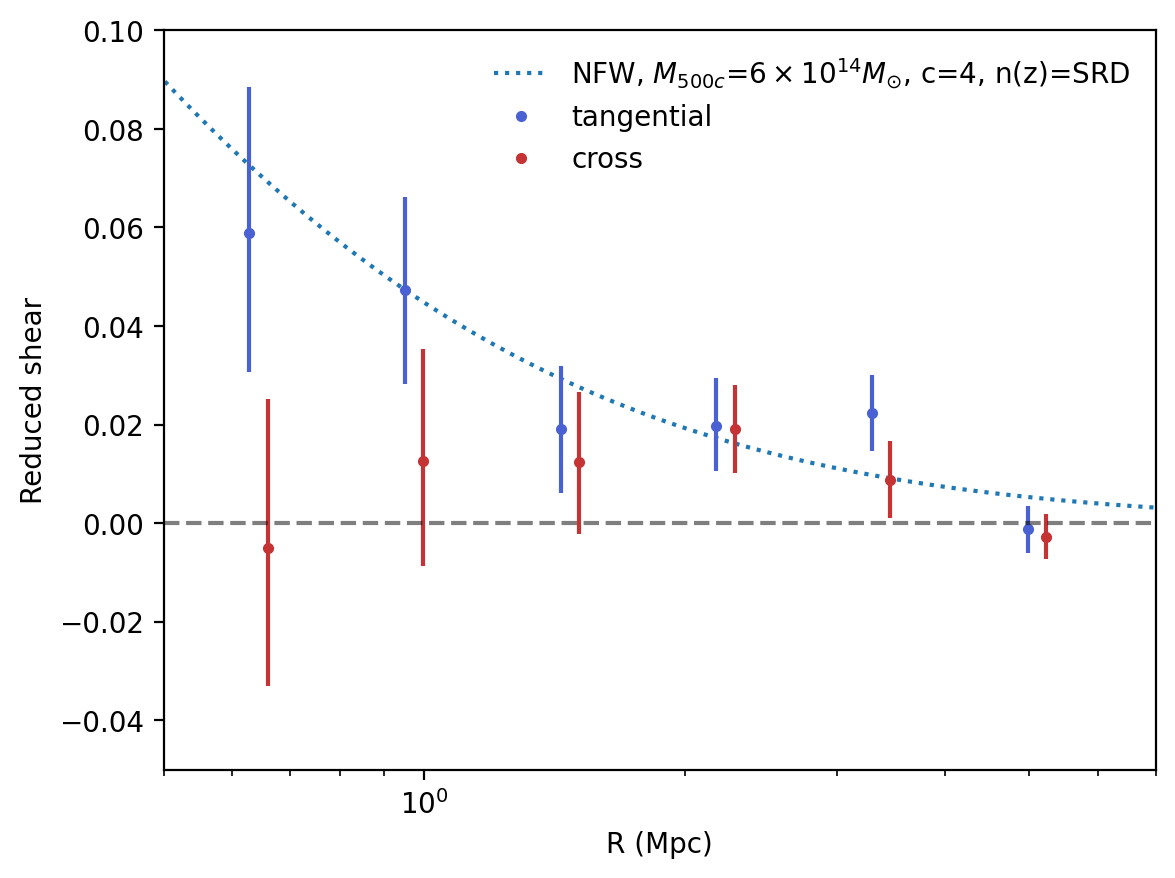

In [85]:
plt.close()
cmap = cm.coolwarm

plt.plot(rproj, gt_z, label=r'NFW, $M_{500c}$=$6 \times 10^{14} M_{\odot}$, c=4, n(z)=SRD', ls=':')
plt.plot(bin_mids, shear_cl[0], '.', label='tangential', color=cmap(.05))
plt.vlines(bin_mids, shear_cl[2][:,0], shear_cl[2][:,1], color=cmap(0.05))
print(np.abs(shear_cl[2][:,0] - shear_cl[2][:,1]) / 2.0)

plt.plot(1.05*bin_mids, shear_cl[1], '.', label='cross', color=cmap(.95))
plt.vlines(1.05*bin_mids, shear_cl[3][:,0], shear_cl[3][:,1], color=cmap(0.95))
print(
    np.sum(shear_cl[1] ** 2.0 / ((shear_cl[3][:,0] - shear_cl[3][:,1]) / 2.0) ** 2.0)
)

plt.semilogx()
plt.axhline(0, ls='--', color='k', alpha=.5)

plt.ylim([-0.05,0.10])
plt.xlim([0.5,7])
plt.ylabel("Reduced shear")
plt.xlabel("R (Mpc)")
plt.legend(frameon=False, loc='upper right')
# plt.savefig("tangential_shear.png")

In [14]:
# Mass Mapping code  from Anthony Englert
def schirmer_filter(radius,aperture_size=8000,x_cut=0.15,a=15,b=150,c=47,d=50,*_):
    '''
    The Schirmer Filter, a filter which is optimized for detecting NFW-like structures in shear-fields.
    Args:
        radius: Numpy array; an array of radii to evaluate the filter on
        aperture_size: float-like; the 'schirmer-radius' of the filter
        x_cut: float-like; specifies the filter-sloap and sets the characteristic-scale of the filter to x_cut*smoothing
    
    Returns:
        Q; Numpy array; an array containing the filter evaluated at each radius
    
    '''
    
    x = radius/aperture_size
    Q = ( 1/( 1 + np.exp(a - b*x) + np.exp(-c + d*x)) )*( np.tanh(x/x_cut)/(x/x_cut) )
    return Q
    
def compute_mass_map(x_grid,y_grid,x,y,g1,g2,weights,q_filter,filter_kwargs={}):
    '''
    This function computes the mass aperture-statistics at each point on a specified grid. Run quality-cuts, NaN filtering, etc. before this step!
    
    Args:
        x: Numpy array; an array of x-coordinates for each object
        y: Numpy array; an array of y-coordinates for each object
        x_grid: Numpy array; an NxM array of x-coordinates to sample the aperture-mass on
        y_grid: Numpy array; an NxM array of y-coordinates to sample the aperture-mass on
        g1; Numpy array; the shear g1 for each object
        g2; Numpy array; the shear g2 for each object
        weights: Numpy array; the weight for each object's shear
        q_filter; function; the filter-function used to compute Map
        kwargs; dict; kwargs passed to w_filter
    
    Returns:
        Map_E: Numpy array; an NxM array containing the E-mode aperture mass evaluated at each grid-point
        Map_B: Numpy array; an NxM array containing the B-mode aperture mass evaluated at each grid-point
        Map_V: Numpy array; an NxM array containing the variance in the aperture mass evaluated at each grid-point

    '''

    y_shape = len(y_grid[:,0])
    x_shape = len(x_grid[0,:])
    
    Map_E = np.zeros((y_shape,x_shape))
    Map_B = np.zeros((y_shape,x_shape))
    Map_V = np.zeros((y_shape,x_shape))
    
    if 'aperture_size' not in filter_kwargs:
        filter_area = np.pi * (0.55)**2
    else:
        filter_area = np.pi * filter_kwargs['aperture_size']**2
    
    comp_shear = g1 + 1j*g2
    g_mag = g1**2 + g2**2
    
    for i in range(y_shape):
        for j in range(x_shape):
            delta_x =  x - x_grid[j, i]
            delta_y =  y - y_grid[j, i]
            radius = np.sqrt(delta_x**2 + delta_y**2)
            theta = np.arctan2(delta_y,delta_x)
            rotated_shear = comp_shear * -1*np.exp(-2j*theta)
            g_T = rotated_shear.real
            g_X = rotated_shear.imag
            filter_values = q_filter(radius,**filter_kwargs)
            weight_sum = np.sum(weights)
            Map_E[i,j] = np.sum(filter_values*g_T*weights)*filter_area/weight_sum
            Map_B[i,j] = np.sum(filter_values*g_X*weights)*filter_area/weight_sum
            Map_V[i,j] = np.sum( (filter_values**2)*g_mag*(weights**2) )*(filter_area**2)/(2*(weight_sum**2))
    return Map_E, Map_B, Map_V

In [15]:
ra_bcg, dec_bcg = (cluster_coords[0], cluster_coords[1])
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel
from astropy.coordinates import SkyCoord

# build wcs centered on BCG
flat_wcs = WCS(naxis=2)
crval_sky = [ra_bcg*u.deg,dec_bcg*u.deg]
flat_wcs.wcs.crval = [ra_bcg,dec_bcg]
flat_wcs.wcs.crpix = [0,0] # assign 0,0 to the center, shouldn't matter
flat_wcs.wcs.cdelt = [-0.2/3600,0.2/3600] # match angular resolution of LSST, 0.2"
flat_wcs.wcs.ctype = ["RA---TAN", "DEC--TAN"]
flat_wcs.wcs.radesys = 'ICRS'
flat_wcs.wcs.equinox = 2000
flat_wcs.wcs.cd = [[-0.2/3600,0],[0,0.2/3600]]

# compute coords in the flat-sky
# coords = SkyCoord(ra=merged_cat_wl['coord_ra'][source_filt][to_use],dec=merged_cat_wl['coord_dec'][source_filt][to_use],unit='degree')
coords = SkyCoord(ra=anacal_table['ra'],dec=anacal_table['dec'],unit='degree')
x,y = skycoord_to_pixel(coords,wcs=flat_wcs)

# scale these up to units of degrees to match mass_map spacing and make writing the aperture easier
x = x * 0.2/3600
y = y * 0.2/3600

# for now I'll weight everything uniformly
weights = np.ones(len(x))

# Define an NxN grid centered on the cluster
# Spans 1-deg centered at the BCG
# scale so that its in pixel coordinates for computing
N = 121

mid_x = 0
mid_y = 0
x_grid_samples = np.linspace(mid_x-0.5,mid_x+0.5,N)
y_grid_samples = np.linspace(mid_y-0.5,mid_y+0.5,N)
y_grid,x_grid = np.meshgrid(y_grid_samples,x_grid_samples)

In [16]:
# Using a global R for the first try:
global_R = np.mean(res)
print(global_R)
weights = np.ones(len(x))
g1 = e1 / global_R
g2 = e2 / global_R

0.4491915780450713


In [17]:
e_ap,b_ap,v_ap = compute_mass_map(
    x_grid,y_grid,
    x,y,
    g1,g2,
    weights,
    schirmer_filter,
    filter_kwargs={'aperture_size':0.4}
)

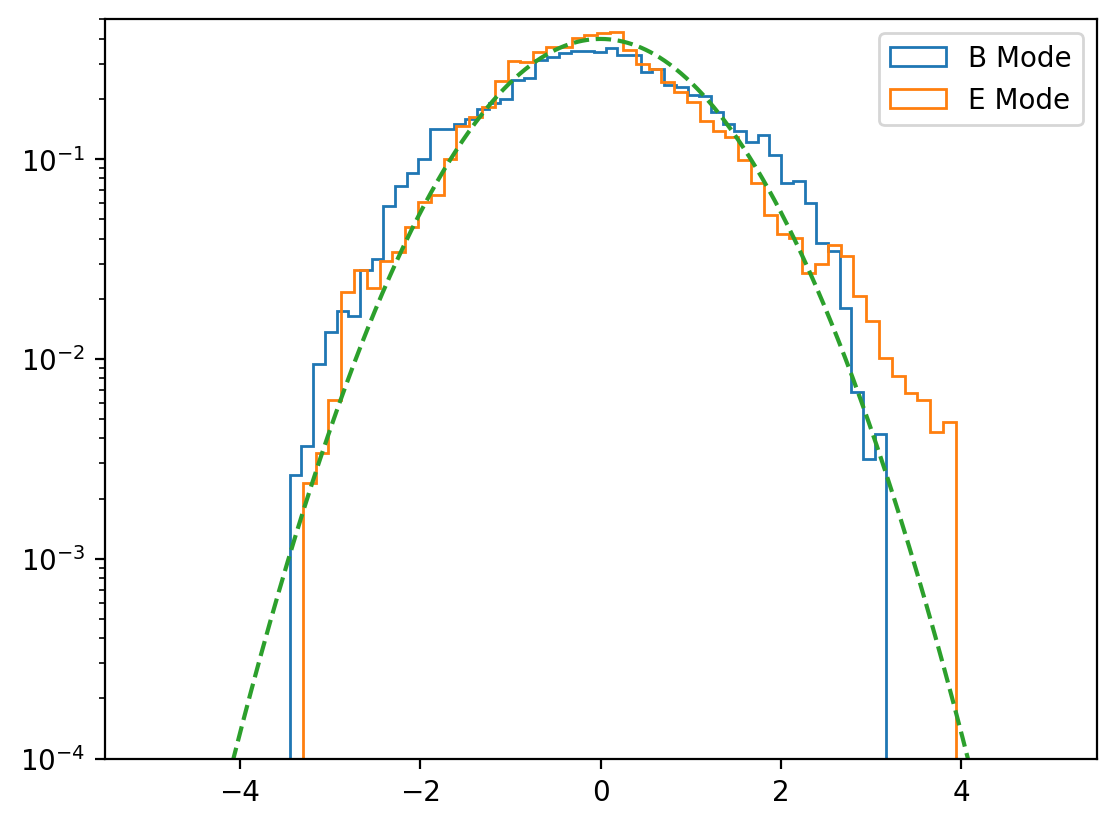

In [18]:
sky_box = np.array([[x_grid.max(), x_grid.min()],[y_grid.min(), y_grid.max()]])
test_xs = np.linspace(-5, 5, num=1001)
standard = stats.norm(0, 1)
normal_dist = standard.pdf(test_xs)
plt.hist((b_ap/np.sqrt(v_ap)).flatten(), bins=51, label='B Mode', histtype='step', density=True)
plt.hist((e_ap/np.sqrt(v_ap)).flatten(), bins=51, label='E Mode', histtype='step', density=True)
plt.plot(test_xs, normal_dist, '--')
plt.legend();
plt.yscale("log")
plt.ylim(1e-4, 5e-1)
# plt.savefig("massmap_histogram.png")

(0.02, 0.5)

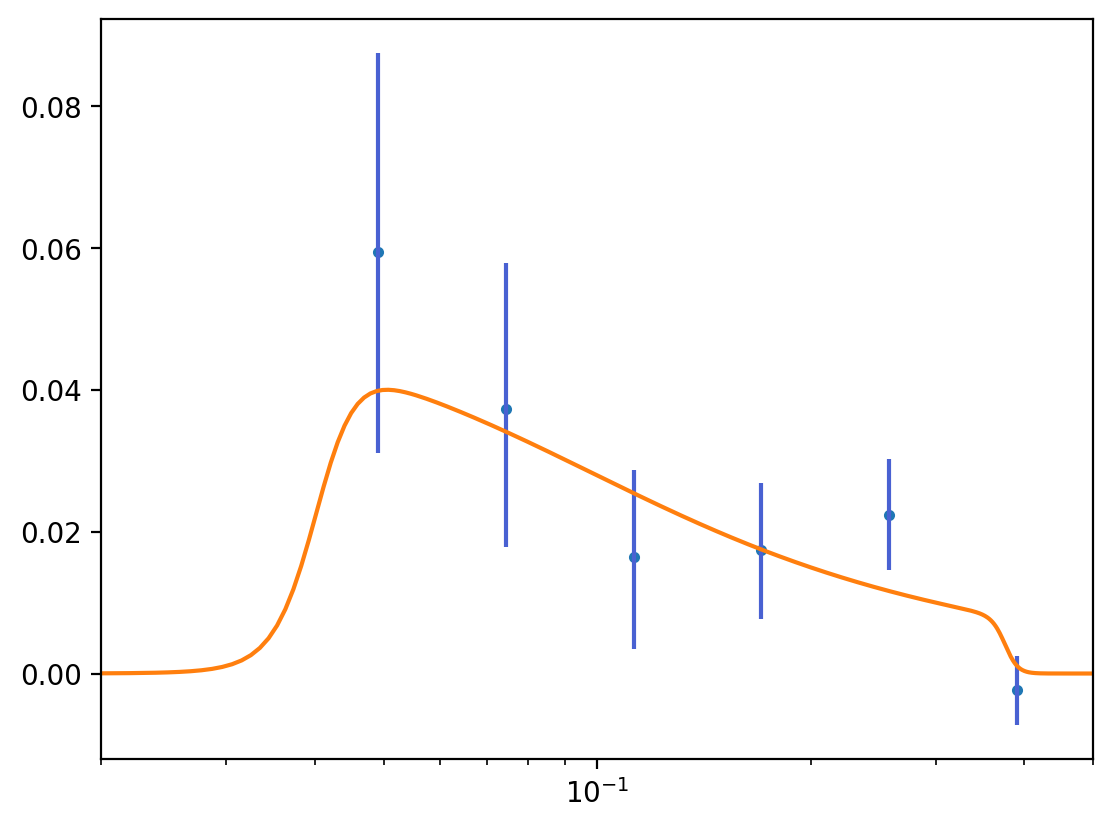

In [19]:
plt.plot(bin_mids / ( Da(z_cl) * (np.pi/180)), shear_cl[0], '.')
plt.vlines(bin_mids/ ( Da(z_cl) * (np.pi/180)), shear_cl[2][:,0], shear_cl[2][:,1], color=cmap(0.05))
x = np.linspace(0.02, 0.5, 500)
plt.plot(x, schirmer_filter(x, aperture_size=0.4, a=15, b=150) / 20)
plt.xscale("log")
plt.xlim(0.02, 0.5)

[60] [61]
[3.93774313]


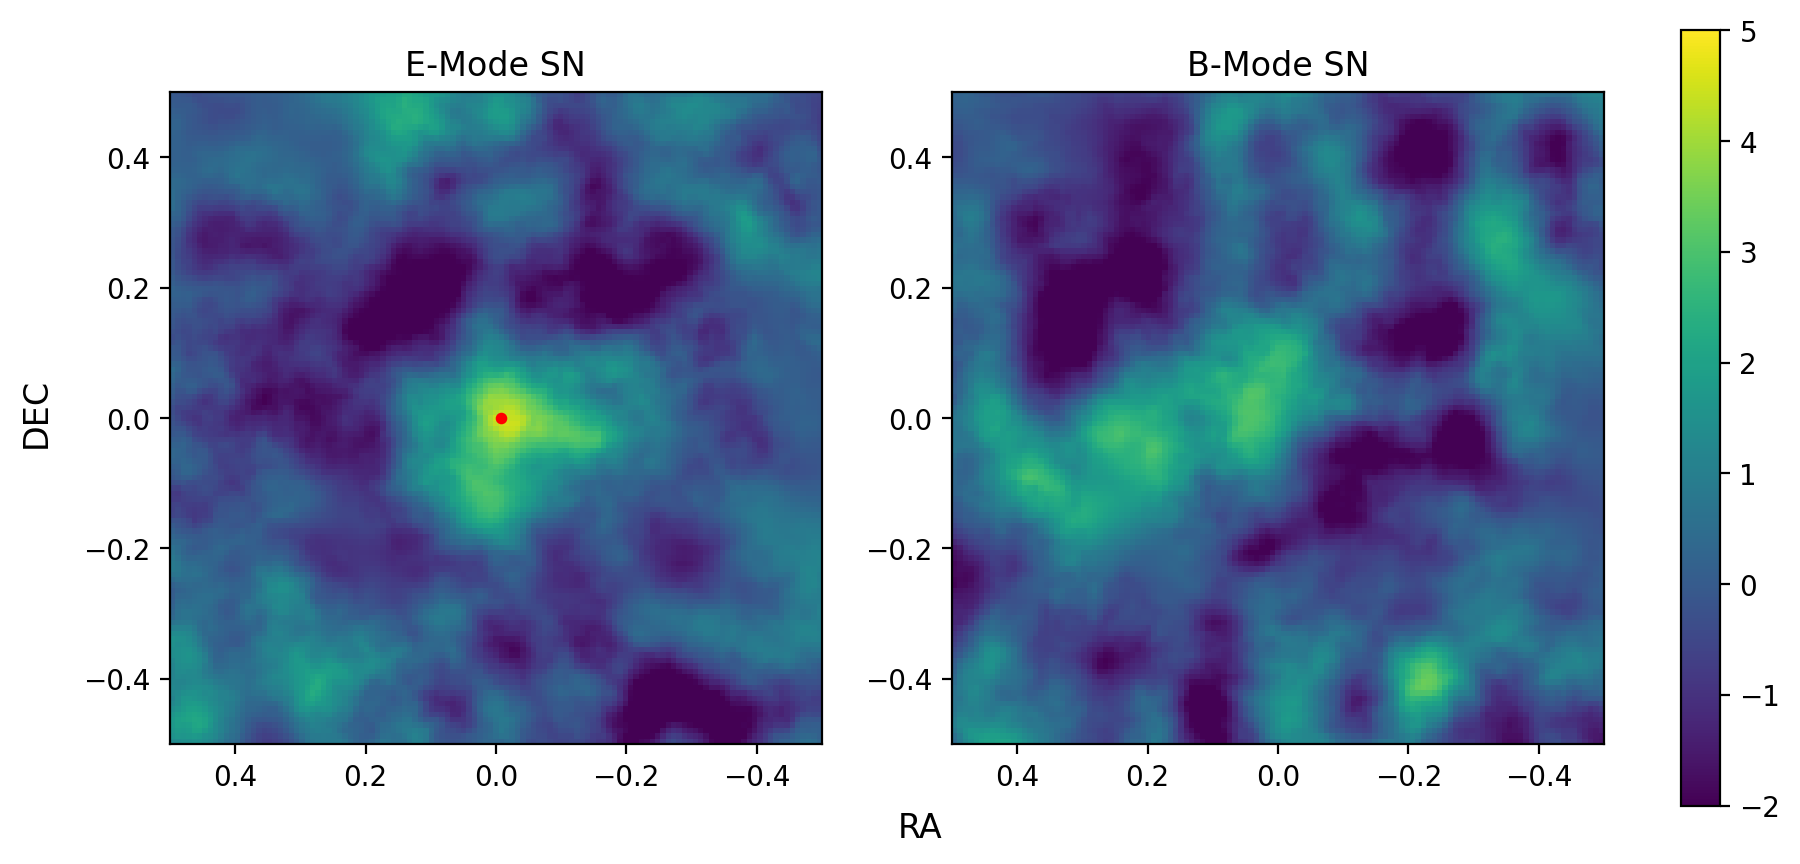

In [20]:
fig, axs = plt.subplots(ncols=2,figsize=(10,6))

ax = axs[0]
ax.set_title('E-Mode SN')
extent=(0.5, -0.5, -0.5, 0.5)
MapE = ax.imshow(
    e_ap /np.sqrt(np.mean(v_ap)),
    vmin=-2, vmax=5,
    origin='lower', 
    extent=extent
)
y , x =np.where(e_ap /np.sqrt(np.mean(v_ap)) == np.max(e_ap /np.sqrt(np.mean(v_ap))))
print(y, x)
print((e_ap /np.sqrt((v_ap)))[y, x])
x_vals = np.linspace(extent[0], extent[1], N)
y_vals = np.linspace(extent[2], extent[3], N)
x_coord = x_vals[x]
y_coord = y_vals[y]
ax.scatter(x_coord, y_coord, s=10.0, color="red")

ax = axs[1]
ax.set_title('B-Mode SN')
MapB = ax.imshow(
    b_ap/np.sqrt(np.mean(v_ap)),
    vmin=-2, vmax=5,
    origin='lower', 
    extent=extent,
)

# for xx in axs:
#     xx.plot(ra_bcg, dec_bcg, 'rx')
cbar = fig.colorbar(MapE, ax=axs,fraction=0.025)

fig.supxlabel("RA", y=0.14)
fig.supylabel("DEC", x=0.05)
# plt.savefig("massmap_map.png")

In [21]:
np.max(e_ap /np.sqrt(np.mean(v_ap)))

np.float64(4.551963317483682)

In [22]:
np.max(b_ap /np.sqrt(np.mean(v_ap)))

np.float64(3.42124424840186)


# Photo-z Matching

In [33]:
import pandas as pd
import qp
from scipy.spatial import KDTree
from astropy.coordinates import SkyCoord

In [34]:
# Running at USDF RSP?
pz_sv38_point = '/sdf/data/rubin/shared/pz/projects/dp1/data/gold_baseline/dp1_sv38/dp1_v29.0.0_gold_Rubin_SV_38_7_photoz_cat.parquet'
pz_ecdfs_point = '/sdf/data/rubin/shared/pz/projects/dp1/data/gold_baseline/dp1_all/dp1_v29.0.0_gold_photoz_cat.parquet'
# pz_sv38_pdf_dir = '/home/z/ztq1996/comm_pz/dp1_run/rail_project_root/projects/dp1/data/gold_dp1_optimize_4band/dp1_sv38/'
pz_ecdfs_pdf_dir = '/sdf/data/rubin/shared/pz/projects/dp1/data/gold_baseline/dp1_all'
pz_sv38_pdf_dir = '/sdf/data/rubin/shared/pz/projects/dp1/data/gold_baseline/dp1_sv38'

# Running at NERSC?
# pz_sv38_pdf_dir = '/global/cfs/cdirs/lsst/groups/PZ/DP1/projects/dp1_v4/data/gold_dp1_4band'
# pz_ecdfs_pdf_dir = '/global/cfs/cdirs/lsst/groups/PZ/DP1/projects/dp1_v4/data/gold_dp1_6band'

In [35]:
bands = list('griz')
cmodel_bands = [b+suffix for b in bands for suffix in ['_cModelFlux', '_cModelFluxErr', '_cModel_flag']]
gaap_bands = [b+suffix for b in bands for suffix in ['_gaap1p0Flux', '_gaap1p0FluxErr',  '_gaapFlux_flag']]
psf_bands = [b+suffix for b in bands for suffix in ['_psfFlux', '_psfFluxErr',  '_psfFlux_flag']]
extended_bands = [b+'_extendedness' for b in bands]

object_req_cols = ['coord_ra', 'coord_dec', 'refExtendedness', 'objectId',
            'parentObjectId', 'shape_xx', 'shape_xy', 'shape_yy', 'refBand', 'x', 'y',
            'patch', 'tract', 'i_ixxPSF', 'i_iyyPSF', 'i_ixyPSF', 'i_iPSF_flag',
            'i_hsmShapeRegauss_e1', 'i_hsmShapeRegauss_e2',
            'i_hsmShapeRegauss_flag', 'i_hsmShapeRegauss_sigma', 'i_blendedness' ] + cmodel_bands + gaap_bands + extended_bands + psf_bands

In [36]:
def get_pdfs(algo_type, filt, pz_dir, weights=None):
    xs = np.linspace(0, 3, 301)
    pdfs = qp.read(f'{pz_dir}/output_estimate_{algo_type}.hdf5')
    pdf_plot = pdfs[filt].pdf(xs)
    if weights is None:
        stacked_plot = np.sum(pdf_plot, axis=0)
        normalized_plot = stacked_plot / len(filt)
    else:
        stacked_plot = np.dot(weights, pdf_plot)
        normalized_plot = stacked_plot / np.sum(weights)
        
    # stacked_plot_all = np.sum(pdf_plot, axis=0)
    # normalized_plot_all = stacked_plot_all / len(pdf_plot)

    return normalized_plot, pdf_plot, xs

In [37]:
def load_pz_photomdata(tracts=[10463, 10464, 10704],
                       ddir='/sdf/data/rubin/shared/pz/data/dp1_v29.0.0_gold/',
                       suffix = 'pq',
                       columns=object_req_cols
                      ):
    object_cat = []


    for tract in tracts:
        tract_data = pd.read_parquet(ddir+str(tract)+'/object.' + suffix)
        relevant_data = Table.from_pandas(tract_data[columns])
        object_cat.append(relevant_data)

    preclean_table = vstack(object_cat)

    for b in list('griz'):
        preclean_table[f'{b}_cModel_mag'] = u.nJy.to(u.ABmag, preclean_table[f'{b}_cModelFlux'])
        preclean_table[f'{b}_gaap_mag'] = u.nJy.to(u.ABmag, preclean_table[f'{b}_gaap1p0Flux'])

    preclean_table['gi'] = preclean_table['g_gaap_mag'] - preclean_table['i_gaap_mag']
    preclean_table['gr'] = preclean_table['g_gaap_mag'] - preclean_table['r_gaap_mag']
    preclean_table['ri'] = preclean_table['r_gaap_mag'] - preclean_table['i_gaap_mag']

    c1 = SkyCoord(preclean_table['coord_ra']*u.deg, preclean_table['coord_dec']*u.deg)
    c2 = SkyCoord(cluster_coords[0]*u.deg, cluster_coords[1]*u.deg)
    sep = c1.separation(c2)
    preclean_table['sep'] = sep.deg
    return preclean_table

In [38]:
# # Get point estimates for the entire field (169034 objects)
pz_ests = pd.read_parquet(pz_sv38_point)
pz_ests = Table.from_pandas(pz_ests)

In [39]:
# pz_alldata = load_pz_photomdata()
# pz_data = pz_alldata[pz_alldata['sep'] < 0.5]

pz_data = load_pz_photomdata()

/opt/lsst/software/stack/conda/envs/lsst-scipipe-12.0.0/lib/python3.13/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/opt/lsst/software/stack/conda/envs/lsst-scipipe-12.0.0/lib/python3.13/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


In [40]:
pz_alldata = join(pz_data, pz_ests, keys='objectId')

In [41]:
pz_coords = np.vstack((pz_alldata['coord_ra'], pz_alldata['coord_dec'])).T
pz_tree = KDTree(pz_coords)

ana_coords = np.vstack((anacal_table['ra'], anacal_table['dec'])).T
ana_tree = KDTree(ana_coords)

In [42]:
dists, pz_ndxs =  pz_tree.query(ana_coords, k=2)

Text(0, 0.5, 'Counts')

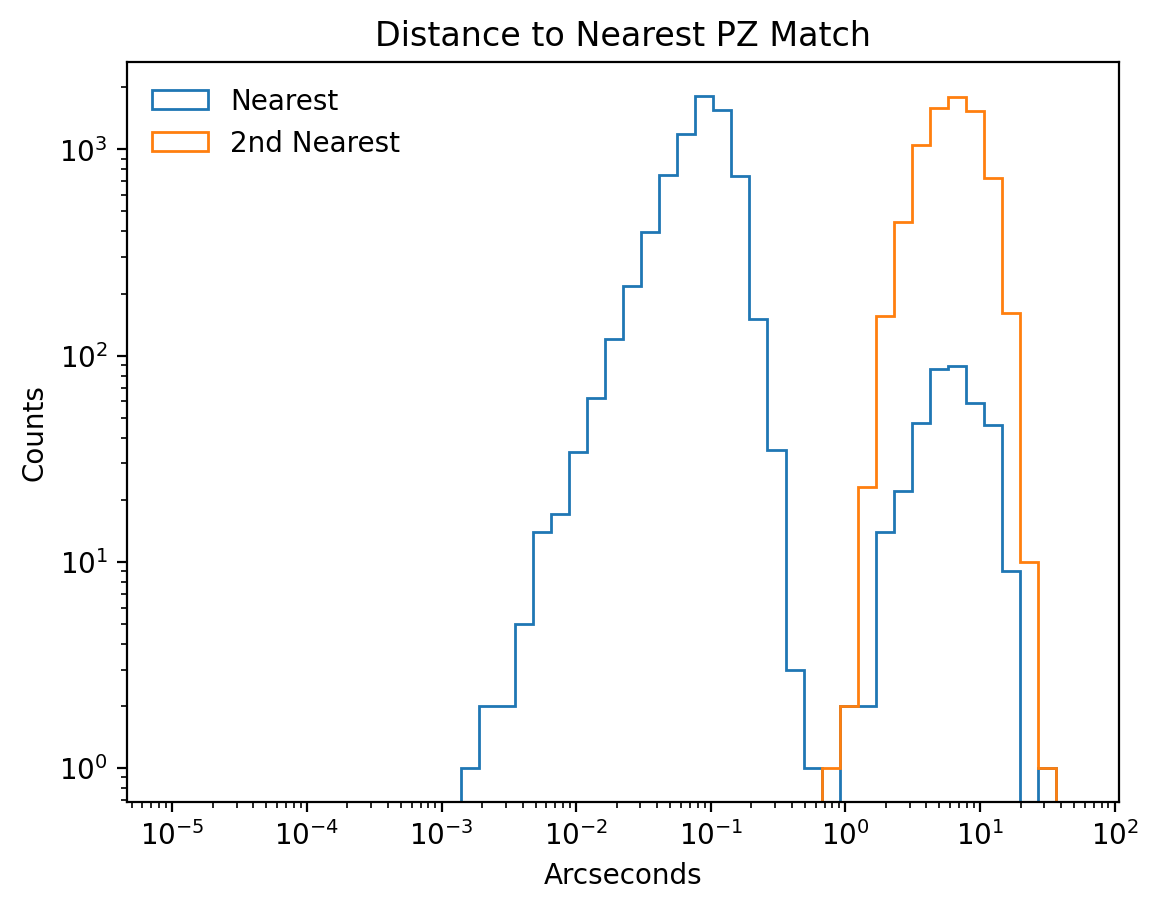

In [43]:
logbins = np.geomspace(1e-5, 50, 51)
plt.hist(dists[:,0] * 3600, bins=logbins, histtype='step', label='Nearest')
plt.hist(dists[:,1] * 3600, bins=logbins, histtype='step', label='2nd Nearest')
plt.legend(frameon=False)
plt.semilogx()
plt.semilogy()
plt.title("Distance to Nearest PZ Match")
plt.xlabel("Arcseconds")
plt.ylabel("Counts")

In [44]:
N_ana = len(anacal_table)
goodmatch_filt = dists[:,0] < 1/3600
print(f"Num anacal: {N_ana}. Num matches: {np.sum(goodmatch_filt)}")

Num anacal: 7525. Num matches: 7114


In [45]:
anacal_pz_table = anacal_table[goodmatch_filt]

In [46]:
pz_goodndx = pz_ndxs[goodmatch_filt, 0]
pz_gooddata = pz_alldata[pz_goodndx]

pz_cols = list(pz_ests.columns)

for col in pz_cols:
    if col=='objectId':
        continue
    anacal_pz_table[col] = pz_gooddata[col]

In [47]:
Rpz = np.mean(anacal_pz_table['res'])

In [48]:
anacal_pz_table['cal_e1'] = anacal_pz_table['correct_e1']/Rpz
anacal_pz_table['cal_e2'] = anacal_pz_table['correct_e2']/Rpz

In [69]:
anacal_pz_table.write('cluster_data/anacal_pz_table.fits', format='fits', overwrite=True)

In [49]:
source_phi = np.arctan2(anacal_pz_table['dec'] - cluster_coords[1], (cluster_coords[0] - anacal_pz_table['ra'])*np.cos(np.deg2rad(cluster_coords[1])))
ang_dist = np.sqrt(((anacal_pz_table['ra'] - cluster_coords[0]) * np.cos(np.deg2rad(cluster_coords[1])))**2 + (anacal_pz_table['dec'] - cluster_coords[1])**2)
sky_distance = Da(.22) * ang_dist * (np.pi/180)

trial_shear = anacal_pz_table['correct_e1'] + 1.j*anacal_pz_table['correct_e2']
cl_shear = trial_shear * -1*np.exp(-2j*source_phi)

bins_mpc = clmm.make_bins(0.5,6,nbins=6, method='evenlog10width')
bin_mids = 1/2 * (bins_mpc[1:] + bins_mpc[:-1])
shear_cl_pz = anacal_get_tang_cross(cl_shear, sky_distance, bins_mpc, anacal_pz_table['res'], ci_level=.68)

In [50]:
moo = clmm.Modeling(massdef="critical", delta_mdef=500, halo_profile_model="nfw")
moo.set_cosmo(cosmo)
moo.set_concentration(4)
moo.set_mass(6e14)
gt_z = moo.eval_reduced_tangential_shear(
    rproj, z_cl, [beta_s_mean, beta_s_square_mean], z_src_info="beta", approx="order2"
)

[0.02898845 0.0190621  0.0124234  0.0095424  0.00767386 0.00475012]
7.072159179909015


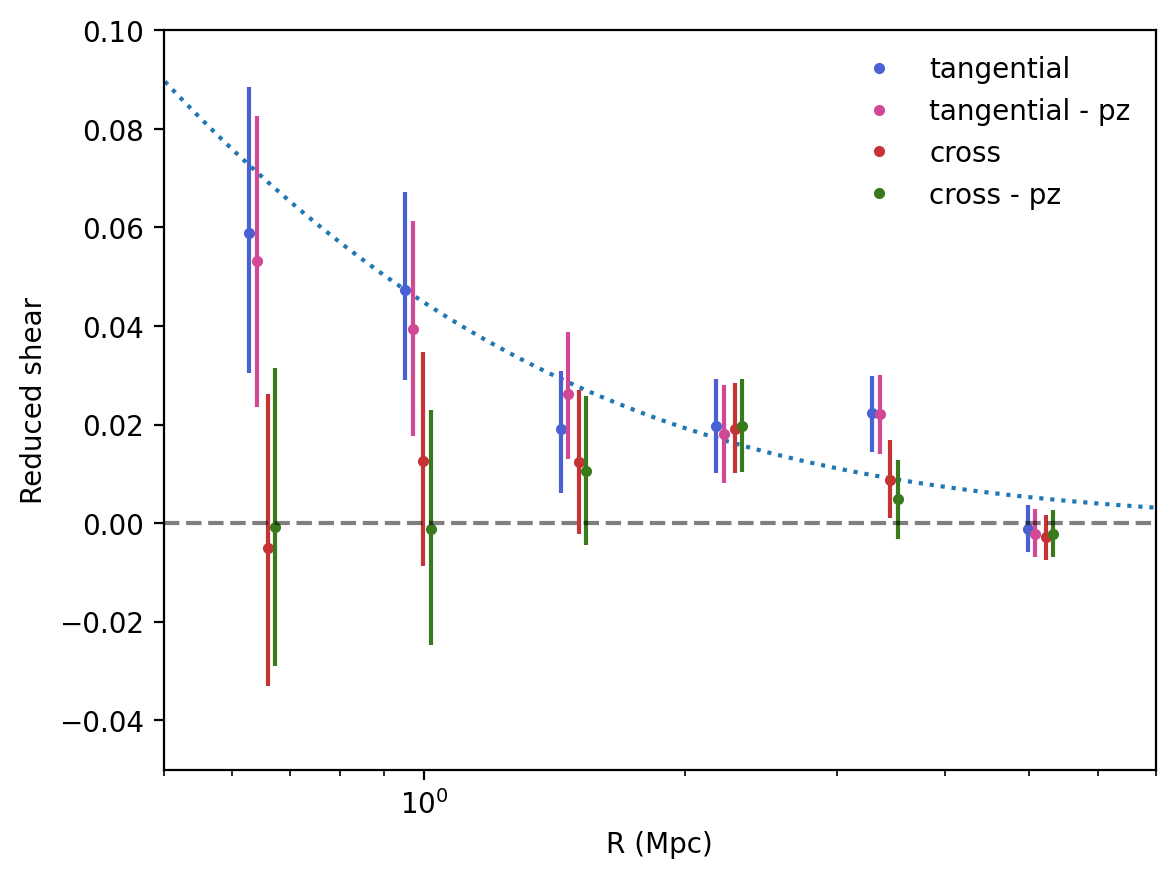

In [51]:
plt.close()
cmap = cm.coolwarm
cmap2 = cm.PiYG

# plt.plot(rproj, gt_z, label=r'NFW, $M_{500c}$=$6 \times 10^{14} M_{\odot}$, c=4, n(z)=SRD', ls=':')
plt.plot(rproj, gt_z, ls=':')
plt.plot(bin_mids, shear_cl[0], '.', label='tangential', color=cmap(.05))
plt.vlines(bin_mids, shear_cl[2][:,0], shear_cl[2][:,1], color=cmap(0.05))

plt.plot(bin_mids*1.02, shear_cl_pz[0], '.', label='tangential - pz', color=cmap2(.15))
plt.vlines(bin_mids*1.02, shear_cl_pz[2][:,0], shear_cl_pz[2][:,1], color=cmap2(0.15))

print(np.abs(shear_cl[2][:,0] - shear_cl[2][:,1]) / 2.0)

plt.plot(1.05*bin_mids, shear_cl[1], '.', label='cross', color=cmap(.95))
plt.vlines(1.05*bin_mids, shear_cl[3][:,0], shear_cl[3][:,1], color=cmap(0.95))
plt.plot(bin_mids*1.07, shear_cl_pz[1], '.', label='cross - pz', color=cmap2(.95))
plt.vlines(bin_mids*1.07, shear_cl_pz[3][:,0], shear_cl_pz[3][:,1], color=cmap2(0.95))

print(
    np.sum(shear_cl[1] ** 2.0 / ((shear_cl[3][:,0] - shear_cl[3][:,1]) / 2.0) ** 2.0)
)

plt.semilogx()
plt.axhline(0, ls='--', color='k', alpha=.5)

plt.ylim([-0.05,0.10])
plt.xlim([0.5,7])
plt.ylabel("Reduced shear")
plt.xlabel("R (Mpc)")
plt.legend(frameon=False, loc='upper right')
plt.savefig("tangential_shear.png")

In [52]:
len(anacal_table)

7525

In [53]:
pz_weights = anacal_pz_table['res']

In [59]:
kale = get_pdfs('dnf', pz_goodndx, pz_dir = pz_sv38_pdf_dir, weights=pz_weights)

In [66]:
kale[0][:3]

0.07168104470297287
0.08613118826345185
0.10231504661335919


In [58]:
# pz_algs = ['bpz', 'tpz', 'fzboost', 'knn']
pz_algs = ['bpz', 'tpz', 'fzboost', 'knn', 'gpz', 'dnf', 'lephare', 'cmnn']
pz_algs = ['bpz', 'fzboost', 'dnf']
wl_pdfs = []

# good_match = ndxs[goodmatch_filt,0]
pz_goodndx = pz_ndxs[goodmatch_filt, 0]

for alg in pz_algs:
    print(f"On {alg} we have {len(pz_goodndx)}")
    pdf, sample_pdf, xs = get_pdfs(alg, pz_goodndx, pz_dir = pz_sv38_pdf_dir, weights=pz_weights)
    np.save(f'cluster_data/anacal_pzs_{alg}.npy', sample_pdf)
    wl_pdfs.append(pdf)

res_wl_pdfs2 = np.array(wl_pdfs)

On bpz we have 7114
On fzboost we have 7114
On dnf we have 7114


In [39]:
# np.save("cluster_data/sv38_nz_anacal_weighted.npy", res_wl_pdfs)

In [45]:
wl_pdfs = np.load('cluster_data/sv38_nz_anacal.npy')

In [46]:
xs = np.linspace(0, 3, 301)

Text(0.5, 1.0, 'Weighted $N(z)$')

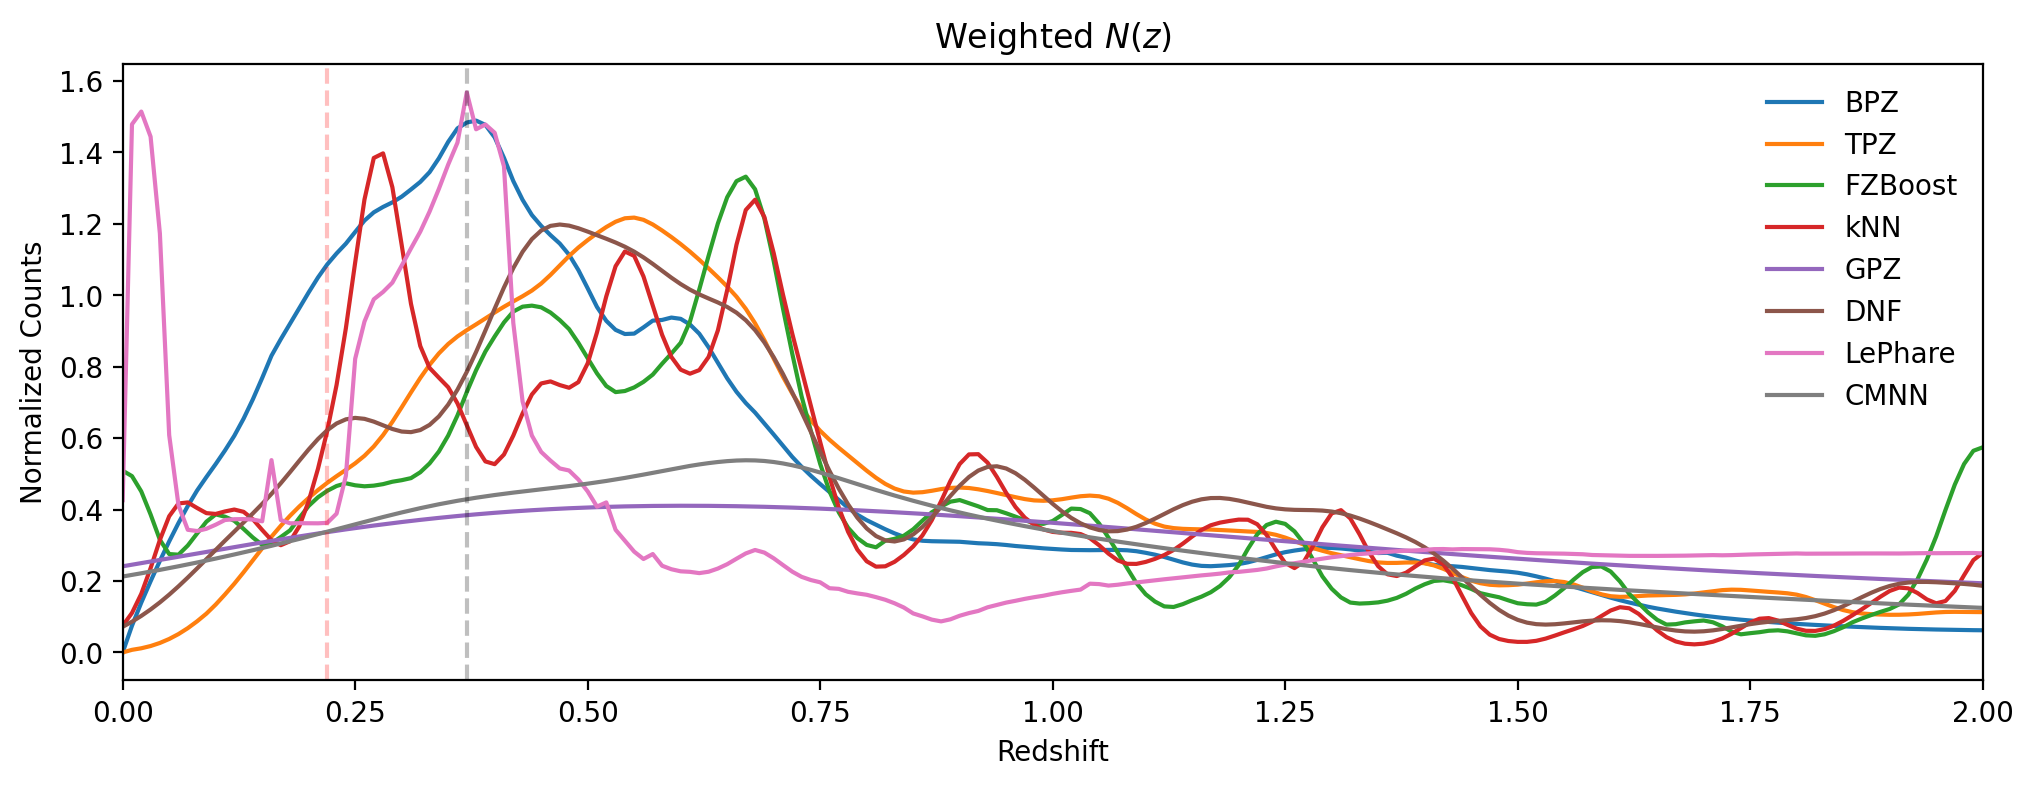

In [231]:
fig, ax = plt.subplots(1, figsize=(12, 4))

pz_algs = ['BPZ', 'TPZ', 'FZBoost', 'kNN', 'GPZ', 'DNF', 'LePhare', 'CMNN']
xs = np.linspace(0, 3, 301)
for i, alg in enumerate(pz_algs):
    ax.plot(xs, res_wl_pdfs[i], label=pz_algs[i])

ax.legend(frameon=False)
ax.set_xlim(0, 2)
ax.set_xlabel("Redshift")
ax.set_ylabel("Normalized Counts")
ax.axvline(0.22, ls='--', color='r', alpha=0.25)
ax.axvline(0.37, ls='--', color='k', alpha=0.25)
ax.set_title("Weighted $N(z)$")
# ax.set_title("N(z) with $z \\geq 0.37$ and $\\sigma_z \\leq 0.25$")

In [132]:
np.sum(wl_pdfs, axis=1)

array([0.00140618, 0.00140572, 0.00141123, 0.0012324 , 0.00111117,
       0.00141829, 0.00141048, 0.00101234])

# CLMM Conversion

In [89]:
# anacal_table.write('cluster_data/anacal_table.fits', format='fits', overwrite=True)

In [90]:
anacal_table = Table.read('cluster_data/anacal_table.fits')

In [92]:
c1 = SkyCoord(anacal_table['ra']*u.deg, anacal_table['dec']*u.deg)
c2 = SkyCoord(cluster_coords[0]*u.deg, cluster_coords[1]*u.deg)
sep = c1.separation(c2)
anacal_table['sep'] = sep.deg
anacal_table['mpc_dist'] = Da(.22) * anacal_table['sep'] * (np.pi/180)

In [93]:
galcat = GCData()
galcat['ra'] = anacal_table['ra']
galcat['dec'] = anacal_table['dec']
galcat['e1'] = anacal_table['correct_e1'] / np.mean(anacal_table['res'])
galcat['e2'] = anacal_table['correct_e2'] / np.mean(anacal_table['res'])
galcat['id'] = np.arange(len(anacal_table))
galcat['z'] = np.zeros(len(anacal_table))

/home/a/adari/.local/lib/python3.13/site-packages/clmm/gcdata.py:30: UserWarning: coordinate_system not set, defaulting to 'euclidean'.
  warnings.warn("coordinate_system not set, defaulting to 'euclidean'.")


In [94]:
ra_bcg = 37.865017
dec_bcg = 6.982205

cluster_id = "Abell 360"
# gc_object1 = clmm.GalaxyCluster(cluster_id, ra_bcg, dec_bcg, 0.22, galcat, coordinate_system='euclidean')
gc_object1 = clmm.GalaxyCluster(cluster_id, ra_bcg, dec_bcg, 0.22, galcat)

gc_object1.compute_tangential_and_cross_components(add=True);
# bins_mpc = np.array([.25, .5, 1, 1.5, 2.27, 3.3, 5, 7]) 
# bins_mpc = clmm.make_bins(0.5,8,nbins=7, method='evenlog10width')
# bins_mpc = clmm.make_bins(0.25,3.74,nbins=7, method='evenlog10width')
# bins_mpc = clmm.make_bins(0.7,3.74,nbins=7, method='evenlog10width')
# bins_mpc = clmm.make_bins(0.5,6,nbins=6, method='evenlog10width')
bins_mpc = np.array([0.3, 0.7       , 1.06495522, 1.62018517, 2.46489237, 3.75    , 5, 6 ])

gc_object1.make_radial_profile(bins=bins_mpc, bin_units='Mpc', add=True, cosmo=cosmo, 
                               overwrite=True, use_weights=False, gal_ids_in_bins=False);

In [95]:
gc_object1.save(f'./cluster_data/technote/profile_anacal_globalresponse')

In [96]:
profile = gc_object1.profile
print(profile)

GCData
> defined by: bin_units='Mpc', coordinate_system='euclidean', cosmo='AstroPyCosmology(H0=70.0, Omega_dm0=0.255, Omega_b0=0.045, Omega_k0=0.0)'
> with columns: radius_min, radius, radius_max, gt, gt_err, gx, gx_err, z, z_err, n_src, W_l
> 7 objects
radius_min       radius       radius_max ... z_err n_src  W_l  
---------- ------------------ ---------- ... ----- ----- ------
       0.3  0.514497066186343        0.7 ...   0.0    52   52.0
       0.7 0.8971118764358962 1.06495522 ...   0.0    92   92.0
1.06495522 1.3763001099739742 1.62018517 ...   0.0   229  229.0
1.62018517 2.0514657249831485 2.46489237 ...   0.0   572  572.0
2.46489237  3.079857966474779       3.75 ...   0.0   832  832.0
      3.75 4.5003609328807395        5.0 ...   0.0  1137 1137.0
       5.0  5.482638885650114        6.0 ...   0.0  1211 1211.0


Text(0.5, 1.0, 'Anacal - 0.30 Mpc to 6.00 Mpc')

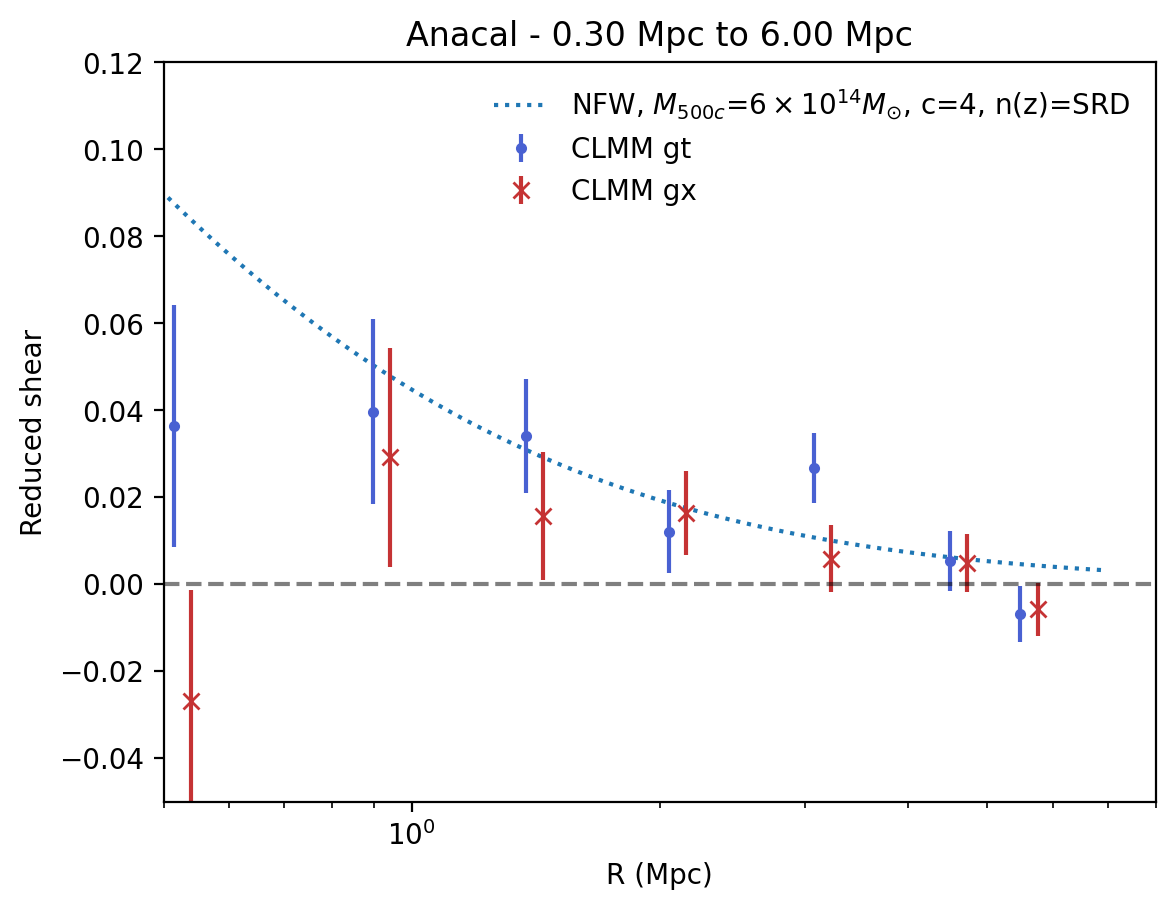

In [97]:
plt.close()
cmap = cm.coolwarm
cmap2 = cm.PiYG

plt.plot(rproj, gt_z, label=r'NFW, $M_{500c}$=$6 \times 10^{14} M_{\odot}$, c=4, n(z)=SRD', ls=':')
# plt.plot(bin_mids, shear_cl[0], '.', label='tangential', color=cmap(.05))
# plt.vlines(bin_mids, shear_cl[2][:,0], shear_cl[2][:,1], color=cmap(0.05))
# print(np.abs(shear_cl[2][:,0] - shear_cl[2][:,1]) / 2.0)

# plt.plot(1.05*bin_mids, shear_cl[1], '.', label='cross', color=cmap(.95))
# plt.vlines(1.05*bin_mids, shear_cl[3][:,0], shear_cl[3][:,1], color=cmap(0.95))
# print(
#     np.sum(shear_cl[1] ** 2.0 / ((shear_cl[3][:,0] - shear_cl[3][:,1]) / 2.0) ** 2.0)
# )

plt.errorbar(profile['radius'], profile['gt'], profile['gt_err'], 
             ls='', marker='.', color=cmap(0.05), label='CLMM gt')
plt.errorbar(profile['radius']*1.05, profile['gx'], profile['gx_err'], 
             ls='', marker='x', color=cmap(0.95), label='CLMM gx')

# for i in range(len(profile)):
#     plt.annotate(f"N={profile['n_src'][i]}", xy=(profile['radius'][i] * .95, -0.045), fontsize=8)

plt.semilogx()
plt.axhline(0, ls='--', color='k', alpha=.5)

plt.ylim([-0.05,0.12])
plt.xlim([0.5,8])
plt.ylabel("Reduced shear")
plt.xlabel("R (Mpc)")
plt.legend(frameon=False, loc='upper right')
plt.title(f"Anacal - {profile['radius_min'][0]:0.2f} Mpc to {profile['radius_max'][-1]:0.2f} Mpc")

In [60]:
3.2/1.22 * 1/.7

3.7470725995316165